# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
# using SQLite Table to read data.
con = sqlite3.connect('../input/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

In [0]:
display['COUNT(*)'].sum()

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [0]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

In [0]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [0]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [0]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

In [0]:
preprocessed_reviews[1500]

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
# splitting data train, cv and test
# train,cv, test split(60:20:20)
X_train = preprocessed_reviews[:int(len(preprocessed_reviews)*0.6)]
y_train = final['Score'][:int(len(preprocessed_reviews)*0.6)]

X_cv = preprocessed_reviews[int(len(preprocessed_reviews)*0.6):int(len(preprocessed_reviews)*0.8)]
y_cv = final['Score'][int(len(preprocessed_reviews)*0.6):int(len(preprocessed_reviews)*0.8)]

X_test = preprocessed_reviews[int(len(preprocessed_reviews)*0.8):]
y_test = final['Score'][int(len(preprocessed_reviews)*0.8):]

print ('training set :', len(X_train))
print ('cross-validation set:',len(X_cv))
print('test set', len(X_test))
print (X_train[:2])


# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
model_bow = count_vect.fit(X_train)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

X_train_bow = count_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_bow))
print("the shape of out text BOW vectorizer ",X_train_bow.get_shape())
print("the number of unique words ", X_train_bow.get_shape()[1])


X_cv_bow = count_vect.transform(X_cv)
print("the type of count vectorizer ",type(X_cv_bow))
print("the shape of out text BOW vectorizer ",X_cv_bow.get_shape())
print("the number of unique words ", X_cv_bow.get_shape()[1])


X_test_bow = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bow))
print("the shape of out text BOW vectorizer ",X_test_bow.get_shape())
print("the number of unique words ", X_test_bow.get_shape()[1])

some feature names  ['aa', 'aaaa', 'aaaaaaaaaaaa', 'aaaaaaaaaaaaaaa', 'aaaaah', 'aaaand', 'aachen', 'aadp', 'aafco', 'aahs']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (27642, 30974)
the number of unique words  30974
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9214, 30974)
the number of unique words  30974
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (9215, 30974)
the number of unique words  30974


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
X_train_bigrams = count_vect.fit_transform(X_train)
print("the type of count vectorizer ",type(X_train_bigrams))
print("the shape of out text BOW vectorizer ",X_train_bigrams.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_bigrams.get_shape()[1])
print ('='*50)
X_cv_bigrams = count_vect.transform(X_cv)
print("the type of count vectorizer ",type(X_cv_bigrams))
print("the shape of out text BOW vectorizer ",X_cv_bigrams.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_cv_bigrams.get_shape()[1])
print ('='*50)
X_test_bigrams = count_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_bigrams))
print("the shape of out text BOW vectorizer ",X_test_bigrams.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_test_bigrams.get_shape()[1])

## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
model_tfidf =tf_idf_vect.fit(X_train)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

X_train_tfidf = tf_idf_vect.transform(X_train)
print("the type of count vectorizer ",type(X_train_tfidf))
print("the shape of out text TFIDF vectorizer ",X_train_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_train_tfidf.get_shape()[1])
print('='*50)
X_cv_tfidf = tf_idf_vect.transform(X_cv)
print("the type of count vectorizer ",type(X_cv_tfidf))
print("the shape of out text TFIDF vectorizer ",X_cv_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_cv_tfidf.get_shape()[1])
print('='*50)
X_test_tfidf = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_test_tfidf))
print("the shape of out text TFIDF vectorizer ",X_test_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_test_tfidf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able buy', 'able eat', 'able enjoy', 'able find', 'able get', 'able give', 'able make', 'able order']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (27642, 16357)
the number of unique words including both unigrams and bigrams  16357
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9214, 16357)
the number of unique words including both unigrams and bigrams  16357
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (9215, 16357)
the number of unique words including both unigrams and bigrams  16357


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance_train=[]
for sentance in X_train:
    list_of_sentance_train.append(sentance.split())
    
list_of_sentance_cv=[]
for sentance in X_cv:
    list_of_sentance_cv.append(sentance.split())
    
list_of_sentance_test=[]
for sentance in X_test:
    list_of_sentance_test.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance_train,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('fantastic', 0.8510028123855591), ('awesome', 0.8465115427970886), ('good', 0.832621157169342), ('excellent', 0.813118577003479), ('terrific', 0.8025708794593811), ('amazing', 0.7900035977363586), ('perfect', 0.7870621085166931), ('wonderful', 0.7802210450172424), ('decent', 0.7558706402778625), ('nice', 0.6829219460487366)]
[('best', 0.762111246585846), ('closest', 0.7606121301651001), ('experienced', 0.7583847045898438), ('tastiest', 0.7393225431442261), ('greatest', 0.7317992448806763), ('ive', 0.725967288017273), ('eaten', 0.7165707349777222), ('nastiest', 0.7126070857048035), ('nicest', 0.6966274380683899), ('hottest', 0.6948556900024414)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))
print ('='*50)
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_cv): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))
print ('='*50)
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance_test): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

  1%|          | 55/9214 [00:00<00:17, 531.35it/s]

27642
50


  0%|          | 31/9215 [00:00<00:29, 308.21it/s]

9214
50


100%|██████████| 9215/9215 [00:18<00:00, 485.56it/s]

9215
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_train = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_train.append(sent_vec)
    row += 1
print (len(tfidf_sent_vectors_train))
print (len(tfidf_sent_vectors_train[0]))
print ('='*50)  
tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_cv): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1
print (len(tfidf_sent_vectors_cv))
print (len(tfidf_sent_vectors_cv[0]))
print ('='*50)    
tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance_test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1
print (len(tfidf_sent_vectors_test))
print (len(tfidf_sent_vectors_test[0]))

  0%|          | 13/9214 [00:00<02:46, 55.29it/s]

27642
50


  0%|          | 7/9215 [00:00<06:28, 23.67it/s]

9214
50


100%|██████████| 9215/9215 [03:01<00:00, 50.11it/s] 

9215
50


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l1', C = i, n_jobs = -1).fit(X_train_bow, y_train)
    pred_train = clf.predict(X_train_bow)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(X_cv_bow)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)
    
    

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5001114330287497, 0.5510738885920924, 0.7547177221635555, 0.9082020821012375, 0.9958804429235503, 0.9991085357700022, 0.999219968798752]
cv auc [0.5, 0.5522411388448035, 0.7481452425228576, 0.8122394956636048, 0.8111342726184559, 0.8027188971181541, 0.7954757076366512]


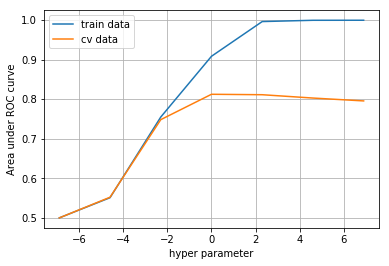

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 1 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l1', C = 1, n_jobs = -1).fit(X_train_bow, y_train)
pred_test = clf.predict(X_test_bow)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.8239864191097473


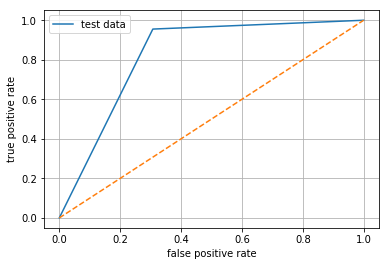

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[1066  473]
 [ 343 7333]]


Text(33,0.5,'actual')

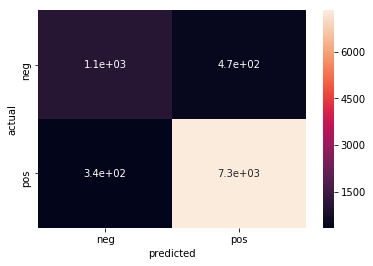

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
from numpy import count_nonzero
w = clf.coef_
sparsity = 1.0 - count_nonzero(w) / w.size
print(sparsity)

0.9115064247433331


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l2', C = i, n_jobs = -1).fit(X_train_bow, y_train)
    pred_train = clf.predict(X_train_bow)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(X_cv_bow)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)
    
    

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5442087814616635, 0.708409591527567, 0.8482079254173036, 0.9501222442703429, 0.9921453021245136, 0.9983285045687541, 0.9991085357700022]
cv auc [0.5390455087716486, 0.6905690249656669, 0.7886184319509237, 0.8196864128953654, 0.8111600725671567, 0.799340523253018, 0.7948021536361062]


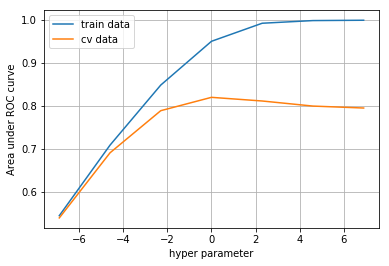

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 1 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l2', C = 1, n_jobs = -1).fit(X_train_bow, y_train)
pred_test = clf.predict(X_test_bow)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.8252200220022002


In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[1071  468]
 [ 349 7327]]


Text(33,0.5,'actual')

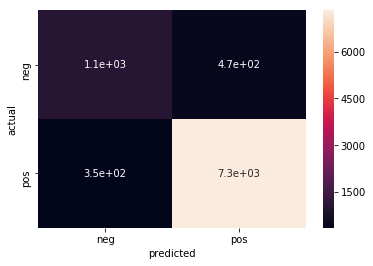

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

In [0]:
# weights from l2 model
w = clf.coef_
print (w)

[[-5.90521534e-01  2.18915109e-02  1.20263993e-04 ... -7.74700141e-02
   6.97171582e-03  6.42154477e-02]]


In [0]:
# addinf small eps value to the weights to avoid division by zero error
w = w + 10**-6
print (w)

[[-5.90520534e-01  2.18925109e-02  1.21263993e-04 ... -7.74690141e-02
   6.97271582e-03  6.42164477e-02]]


In [0]:
# addinf small e= 0.05 value to the bow vectors to perform pertubation test
e = 0.05
X_train_bow.data = X_train_bow.data + e
# now calculating auc and getting weights of the model with l2 model
clf = LogisticRegression(penalty = 'l2', C = 1, n_jobs = -1).fit(X_train_bow, y_train)
pred_test = clf.predict(X_test_bow)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.825025411897915


In [0]:
# obtaining new weights from the model
w_n = clf.coef_
w_n = w_n + 10**-6 # to avoid division by zero error
print (w_n)

[[-5.87717975e-01  2.17002171e-02  1.18218906e-04 ... -8.01084906e-02
   6.16948982e-03  6.28460563e-02]]


In [0]:
# % change in w and w_n
w_diff = (abs(w[0]-w_n[0])/w[0]) * 100
print (w_diff)
print (len(w_diff))

[-0.47459127  0.87835392  2.51112165 ... -3.40713843 11.51955739
  2.13401937]
30974


In [0]:
import math

def percentile(data, percentile):
    size = len(data)
    return sorted(data)[int(math.ceil((size * percentile) / 100)) - 1]

for i in np.arange(0,110,10):
    print ('{}th percentile is {}'.format(i,percentile(w_diff, i)))

0th percentile is 76175.2177780426
10th percentile is -4.556873111413813
20th percentile is -1.5159541120552198
30th percentile is -0.03856177116783109
40th percentile is 0.7873540905732297
50th percentile is 1.724270007754402
60th percentile is 2.9903049607188192
70th percentile is 4.818227474054501
80th percentile is 8.196612713253478
90th percentile is 14.845455946162456
100th percentile is 76175.2177780426


In [0]:

def percentile(low,high,step,array):
    """function to calculate percentiles.
    Input: low,high,step,array. 'array' is the array whose percentiles we want to calculate. 'low is the lowest percentile
           we want to calculate and high is the highest percentile value we want to calculate. 'step' defines the amount of
           step size."""
    for i in np.arange(low,high,step):
        print('The {}th percentile is: {}'.format(i,np.percentile(array,i)))
percentile(0,110,10,w_diff)

The 0th percentile is: -18568.662704061717
The 10th percentile is: -4.5567023683951335
The 20th percentile is: -1.5152631796279745
The 30th percentile is: -0.03870843889191992
The 40th percentile is: 0.7873641483537721
The 50th percentile is: 1.724270007754402
The 60th percentile is: 2.9902943028036417
The 70th percentile is: 4.818246785088136
The 80th percentile is: 8.195777214776781
The 90th percentile is: 14.844617499734419
The 100th percentile is: 76175.2177780426


In [0]:
percentile(90,101,1,w_diff)

The 90th percentile is: 14.844617499734419
The 91th percentile is: 15.983782342862243
The 92th percentile is: 17.412432794665417
The 93th percentile is: 18.781889484540713
The 94th percentile is: 20.24797603649386
The 95th percentile is: 21.88497351980792
The 96th percentile is: 23.90826618010933
The 97th percentile is: 27.19297323049858
The 98th percentile is: 31.156171855121435
The 99th percentile is: 47.07578411704589
The 100th percentile is: 76175.2177780426


In [0]:
percentile(99,100.1,0.1,w_diff)

The 99.0th percentile is: 47.07578411704589
The 99.1th percentile is: 47.07578411704589
The 99.19999999999999th percentile is: 47.1609465471241
The 99.29999999999998th percentile is: 50.194689113263834
The 99.39999999999998th percentile is: 53.768445226014016
The 99.49999999999997th percentile is: 65.56648696339214
The 99.59999999999997th percentile is: 88.25314448188118
The 99.69999999999996th percentile is: 119.41271921861986
The 99.79999999999995th percentile is: 181.81779879156807
The 99.89999999999995th percentile is: 324.13420387794025
The 99.99999999999994th percentile is: 76175.21777773365


In [0]:
#Creating an empty dataframe with feature from bow and w_diff
df = pd.DataFrame()
df['features'] = model_bow.get_feature_names() 
df['w_diff'] = w_diff 

In [0]:
df.sort_values("w_diff", inplace=True)


In [0]:
df[df.w_diff>88.6]

,features,w_diff
7635,digestibilityno,88.679446
25363,soulful,89.487732
9107,entertained,90.363051
9119,enthusiasts,94.326826
10143,figures,95.777835
17080,minestrone,96.757154
24512,showers,102.760859
19380,pakistani,102.838396
13270,hyderabadi,102.838396
314,address,104.741495


### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [0]:

#function to get important features
def most_important_features(model, clf, n=10):
    feature_names = model.get_feature_names()#Here I am getting feature names stored in my model
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names)) #Here I am trying to create a sorted list containing tuples of-
    #-the form (prob,feature_name)
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])#here I am selecting top n important words-
    #- corresponding to positive class and bottom n words corresponding to negative class
    print("\t\t\tNegative\t\t\t\t\t\tPositive")
    print("________________________________________________________________________________________________")
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print("\t%.4f\t%-15s\t\t\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
most_important_features(model_bow,clf)
#Reference:https://stackoverflow.com/questions/11116697/how-to-get-most-informative-features-for-scikit-learn-classifiers

			Negative						Positive
________________________________________________________________________________________________
	-36.4532	machinesince   				34.0393	cortizone      
	-34.3477	farmer         				32.8298	britt          
	-29.4677	laps           				32.1425	expelled       
	-28.8893	exposure       				27.8791	contacted      
	-28.5795	bunny          				27.1953	anneeavon      
	-26.1309	bureau         				26.2374	forming        
	-25.9955	jerkies        				24.7179	fridays        
	-25.8625	budy           				22.4124	crippling      
	-25.2959	factories      				22.3770	dolmas         
	-25.1193	fad            				21.7926	cutlets        


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l1', C = i, n_jobs = -1).fit(X_train_tfidf, y_train)
    pred_train = clf.predict(X_train_tfidf)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(X_cv_tfidf)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5, 0.5, 0.5692001611026591, 0.8145511323121278, 0.9939463592055113, 0.999219968798752, 0.999219968798752]
cv auc [0.5, 0.5, 0.5851152831882525, 0.8052394435627375, 0.8387477322763537, 0.8356522394021492, 0.8342215529264656]


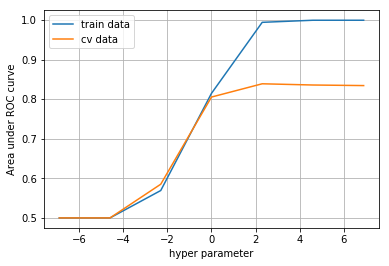

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 10 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l1', C = 10, n_jobs = -1).fit(X_train_tfidf, y_train)
pred_test = clf.predict(X_test_tfidf)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.8421832680344058


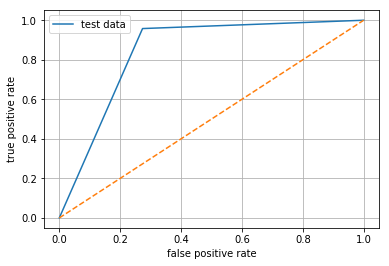

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[1118  421]
 [ 323 7353]]


Text(33,0.5,'actual')

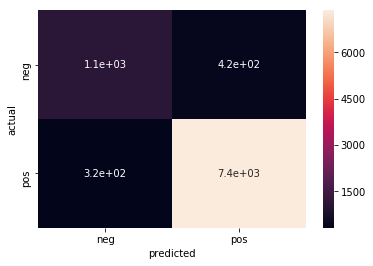

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [0]:
train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l2', C = i, n_jobs = -1).fit(X_train_tfidf, y_train)
    pred_train = clf.predict(X_train_tfidf)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(X_cv_tfidf)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5, 0.5, 0.5341486239885787, 0.8108941317889629, 0.9646957161255262, 0.9989971027412525, 0.999219968798752]
cv auc [0.5, 0.5, 0.5305205878580932, 0.7563644883160466, 0.8359029748259295, 0.8400780577865414, 0.8414175677444867]


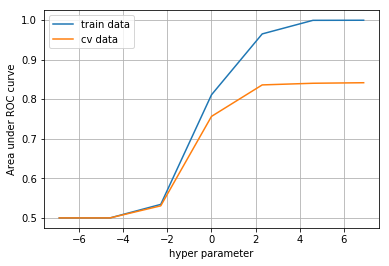

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 1000is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l2', C = 1000, n_jobs = -1).fit(X_train_tfidf, y_train)
pred_test = clf.predict(X_test_tfidf)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.8413983942253875


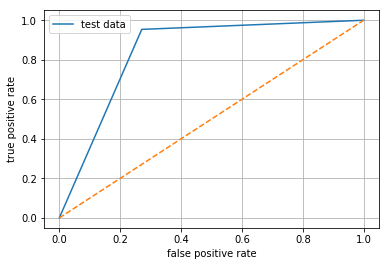

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[1122  417]
 [ 355 7321]]


Text(33,0.5,'actual')

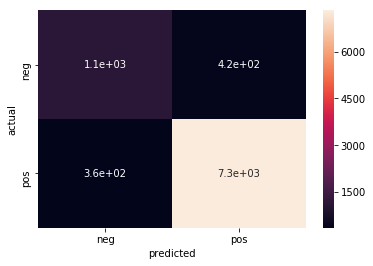

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [0]:
most_important_features(model_tfidf,clf)

			Negative						Positive
________________________________________________________________________________________________
	-36.4532	worst          				34.0393	great          
	-34.3477	not worth      				32.8298	delicious      
	-29.4677	two stars      				32.1425	not disappointed
	-28.8893	not happy      				27.8791	good           
	-28.5795	disappointed   				27.1953	best           
	-26.1309	disappointing  				26.2374	perfect        
	-25.9955	terrible       				24.7179	pleased        
	-25.8625	died           				22.4124	happy          
	-25.2959	not purchase   				22.3770	love           
	-25.1193	not real       				21.7926	hooked         


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [0]:
train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l1', C = i, n_jobs = -1).fit(sent_vectors_train, y_train)
    pred_train = clf.predict(sent_vectors_train)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(sent_vectors_cv)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5, 0.6228113973249432, 0.6955414083546715, 0.7060257043344633, 0.7078086327944588, 0.7079200658232085, 0.7080314988519583]
cv auc [0.5, 0.6033388974387748, 0.677484526710378, 0.6884405709453503, 0.6917565740607148, 0.6917565740607148, 0.6917565740607148]


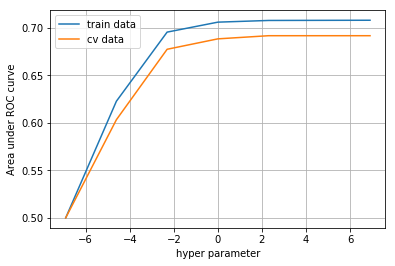

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 10 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l1', C = 10, n_jobs = -1).fit(sent_vectors_train, y_train)
pred_test = clf.predict(sent_vectors_test)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.7128809372165286


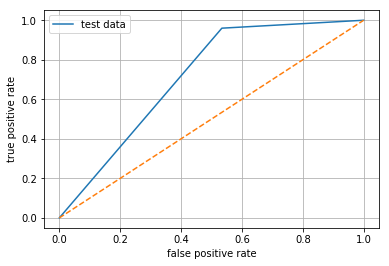

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[ 717  822]
 [ 308 7368]]


Text(33,0.5,'actual')

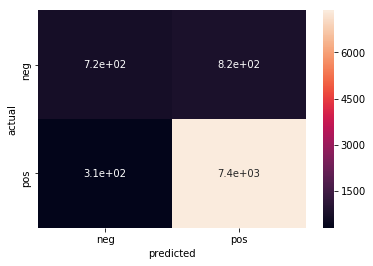

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [0]:
train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l2', C = i, n_jobs = -1).fit(sent_vectors_train, y_train)
    pred_train = clf.predict(sent_vectors_train)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(sent_vectors_cv)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5138350205014155, 0.648520438395967, 0.6946576777838056, 0.7052672667415072, 0.7075209859120836, 0.7079883116353743, 0.7080997446641241]
cv auc [0.5130177022715978, 0.6329442133303409, 0.6774921247535228, 0.687867377910301, 0.6913719126896338, 0.6916911974916773, 0.6916911974916773]


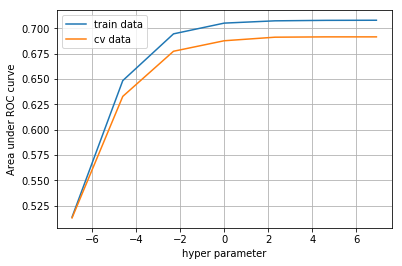

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 100 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l2', C = 100, n_jobs = -1).fit(sent_vectors_train, y_train)
pred_test = clf.predict(sent_vectors_test)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.713011213402042


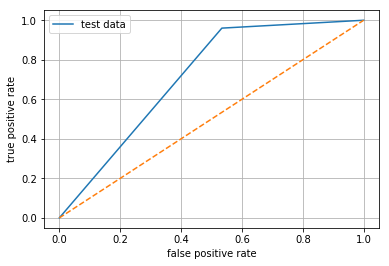

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[ 717  822]
 [ 306 7370]]


Text(33,0.5,'actual')

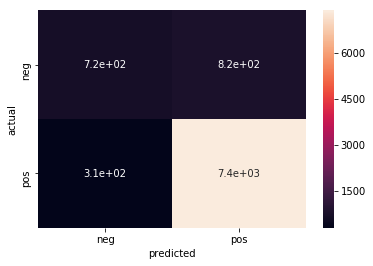

In [0]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l1', C = i, n_jobs = -1).fit(tfidf_sent_vectors_train, y_train)
    pred_train = clf.predict(tfidf_sent_vectors_train)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(tfidf_sent_vectors_cv)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5, 0.588866456839228, 0.654162443512887, 0.6645664913495388, 0.6663814083796964, 0.6663598147714045, 0.6663598147714045]
cv auc [0.5, 0.5760339517305504, 0.639331495775822, 0.6554614734125267, 0.6562809766374367, 0.6569195462415236, 0.6566002614394801]


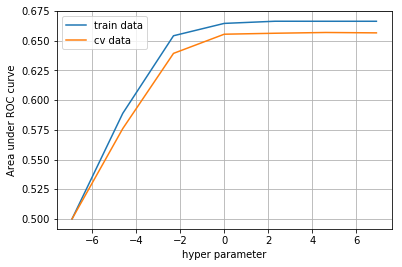

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 100 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l1', C = 100, n_jobs = -1).fit(tfidf_sent_vectors_train, y_train)
pred_test = clf.predict(tfidf_sent_vectors_test)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.6724004271772206


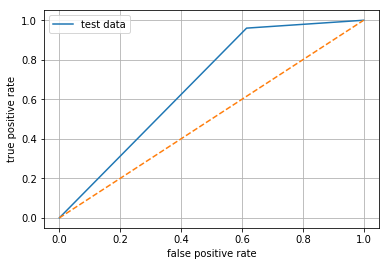

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[ 592  947]
 [ 306 7370]]


Text(33,0.5,'actual')

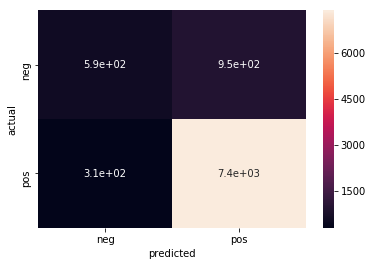

In [0]:
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
 train_auc = []
cv_auc=[]
c = [0.001,0.01,0.1,1,10,100,1000]
for i in c:
    clf = LogisticRegression(penalty = 'l2', C = i, n_jobs = -1).fit(tfidf_sent_vectors_train, y_train)
    pred_train = clf.predict(tfidf_sent_vectors_train)
    train_auc.append(roc_auc_score(y_train, pred_train))
    pred_cv = clf.predict(tfidf_sent_vectors_cv)
    cv_auc.append(roc_auc_score(y_cv, pred_cv))
    
print('train auc',train_auc)
print('cv auc',cv_auc)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logi

train auc [0.5098631536957193, 0.610907799238829, 0.6528071185468882, 0.6638011237820028, 0.6661801359304889, 0.6660255156851553, 0.6660039220768633]
cv auc [0.5083591833790218, 0.598665182459909, 0.6425897203652939, 0.6543150873424282, 0.6559616918353933, 0.6566002614394801, 0.6565348848704425]


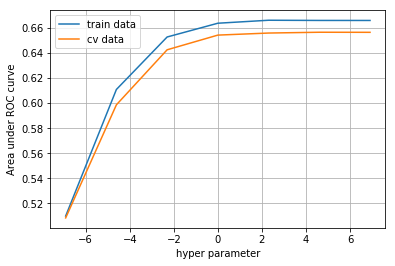

In [0]:
# ploting auc and C for train and cv data
import math
log_c = [math.log(i) for i in c]
plt.plot(log_c , train_auc , label = "train data")
plt.plot(log_c , cv_auc , label = "cv data")
plt.xlabel("hyper parameter")
plt.ylabel("Area under ROC curve")
plt.grid()
plt.legend()
plt.show()

In [0]:
# c = 10 is the parameter value with highest auc value
clf = LogisticRegression(penalty = 'l2', C = 10, n_jobs = -1).fit(tfidf_sent_vectors_train, y_train)
pred_test = clf.predict(tfidf_sent_vectors_test)

print ('auc = ',roc_auc_score(y_test, pred_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1300: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


auc =  0.672075540887422


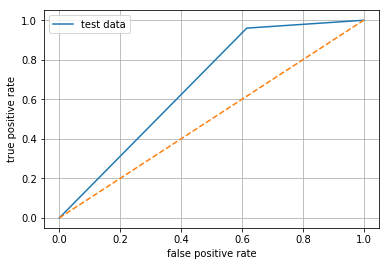

In [0]:
#plotting roc curve test data
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_test)

plt.plot(fpr , tpr , label = "test data")
plt.plot([0,1],[0,1],'--' )
plt.xlabel("false positive rate")
plt.ylabel("true positive rate")
plt.grid()
plt.legend()
plt.show()


[[ 591  948]
 [ 306 7370]]


Text(33,0.5,'actual')

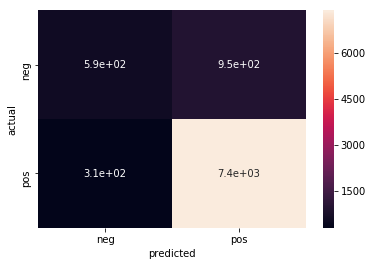

In [0]:
cm = confusion_matrix(y_test, pred_test)
print (cm)
df_cm = pd.DataFrame(cm, index = ['neg','pos'],columns = ['neg','pos'])
sn.heatmap(df_cm, annot=True)
plt.xlabel("predicted")
plt.ylabel("actual")


# [6] Conclusions

In [3]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable

x = PrettyTable()

x.field_names=['Vectorizer','Regularization','HyperParameter','AUC-score']
x.add_row(['BOW','L1',1,0.823])
x.add_row(['BOW','L2',1,0.825])
x.add_row(['tfidf','L1',10,0.842])
x.add_row(['tfidf','L2',1000,0.841])
x.add_row(['AvgW2V','L1',10,0.712])
x.add_row(['AvgW2V','L2',100,0.713])
x.add_row(['tfidfW2V','L1',100,0.672])
x.add_row(['tfidfW2V','L2',10,0.672])
print (x)


+------------+----------------+----------------+-----------+
| Vectorizer | Regularization | HyperParameter | AUC-score |
+------------+----------------+----------------+-----------+
|    BOW     |       L1       |       1        |   0.823   |
|    BOW     |       L2       |       1        |   0.825   |
|   tfidf    |       L1       |       10       |   0.842   |
|   tfidf    |       L2       |      1000      |   0.841   |
|   AvgW2V   |       L1       |       10       |   0.712   |
|   AvgW2V   |       L2       |      100       |   0.713   |
|  tfidfW2V  |       L1       |      100       |   0.672   |
|  tfidfW2V  |       L2       |       10       |   0.672   |
+------------+----------------+----------------+-----------+
